In [ ]:
!pip install -q -U torch_harmonics neuraloperator

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [1]:
from data_generator import generate_potential_data
from utilities import train, validate_model
from structs import TrainInput, ValidationInput, TrainResult, ValidationResult, ErrorType, PlotType, Configuration, DataConfiguration

In [2]:
import accelerate
import torch.nn as nn
import torch.optim as optim
from neuralop.models import FNO

accelerator = accelerate.Accelerator()
device = accelerator.device

## Parameters

In [3]:
# Hyperparameters
num_samples = 500
grid_size = 30
num_eigenvalues = 2
learning_rate = 1e-3
num_epochs = 500

# Initialize the model
fno_model = FNO(
    n_modes=(10, 10),
    hidden_channels=16,
    in_channels=1,
    out_channels=num_eigenvalues,
    lifting_channels=64,
    projection_channels=64,
    n_layers=64
)


# Create optimizer and loss function
optimizer = optim.Adam(fno_model.parameters(), lr=learning_rate)
loss_fn = nn.MSELoss()

In [ ]:
fno_model, optimizer, loss_fn, generate_potential_data = accelerator.prepare(fno_model, optimizer, loss_fn, generate_potential_data)

## Train Harmonic Test Anharmonic

In [ ]:
train_potentials, train_eigen_vals = generate_potential_data(
    num_samples=num_samples,
    dx=0.1,
    dy=0.1,
    max_x_extent=3,
    max_y_extent=3,
    potential_type="harmonic",
    device=device
)
val_potentials, val_eigen_vals = generate_potential_data(
    num_samples=10,
    dx=0.1,
    dy=0.1,
    max_x_extent=3,
    max_y_extent=3,
    potential_type="anharmonic",
    device=device
)

In [ ]:
train_results_1 = train(
    TrainInput(
        train_potentials=train_potentials,
        train_eigen_vals=train_eigen_vals,
        model=fno_model,
        device=device,
        loss_fn=loss_fn,
        num_epochs=num_epochs,
        optimizer=optimizer,
    ),
    accelerator=accelerator,
)

Training: 100%|██████████| 500/500 [02:05<00:00, 3.99epoch/s, loss=0.0027, avg_loss=0.524, time_elapsed=125.23s]


In [ ]:
# train_results_1.save_to_file("train_result_1.pth")
train_results_1 = TrainResult.load_from_file("train_result_1.pth")

### Training Loss

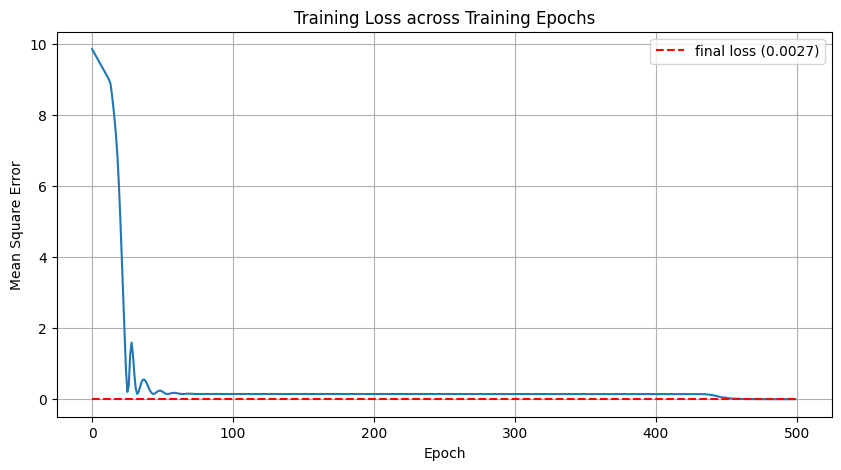

In [ ]:
train_results_1.plot_losses()

In [ ]:
train_results_1 = accelerator.prepare(train_results_1)
model_1 = accelerator.unwrap_model(train_results_1.model)

In [ ]:
validation_results_1 = validate_model(
    ValidationInput(
        val_potentials=val_potentials,
        val_eigen_vals=val_eigen_vals,
        model=train_results_1.model,
        loss_fn=loss_fn,
    )
)

Validation Loss: 0.032803


In [ ]:
validation_results_1.save_to_file("validation_result_1.pth")

### Validation Errors

In [ ]:
validation_results_1.errors()

ValidationErrors(MRE=0.062167294323444366, MSE=0.03516986966133118, MAE=0.14344444870948792, R2=tensor(0.9925))

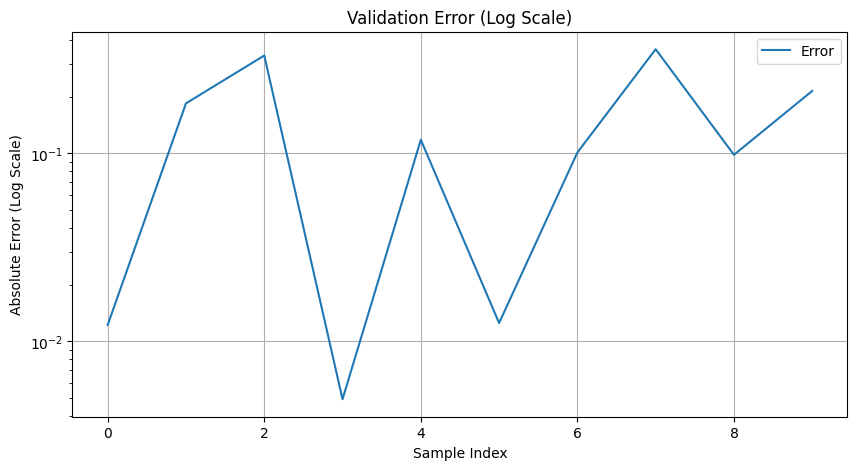

In [ ]:
validation_results_1.plot(error_type=ErrorType.ABSOLUTE)

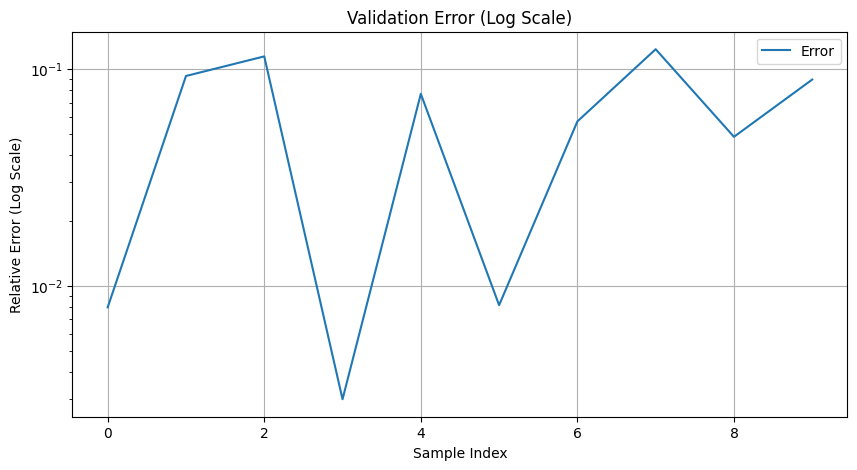

In [ ]:
validation_results_1.plot(error_type=ErrorType.RELATIVE)

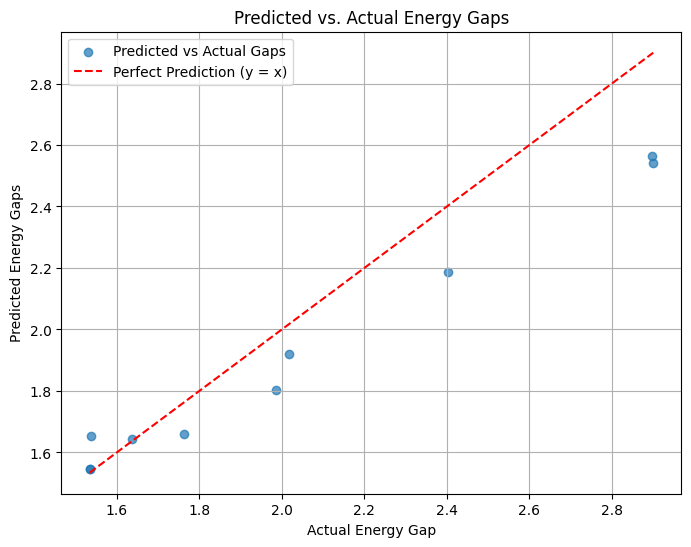

In [ ]:
validation_results_1.visualize_energy_gap(plot_type=PlotType.SCATTER)

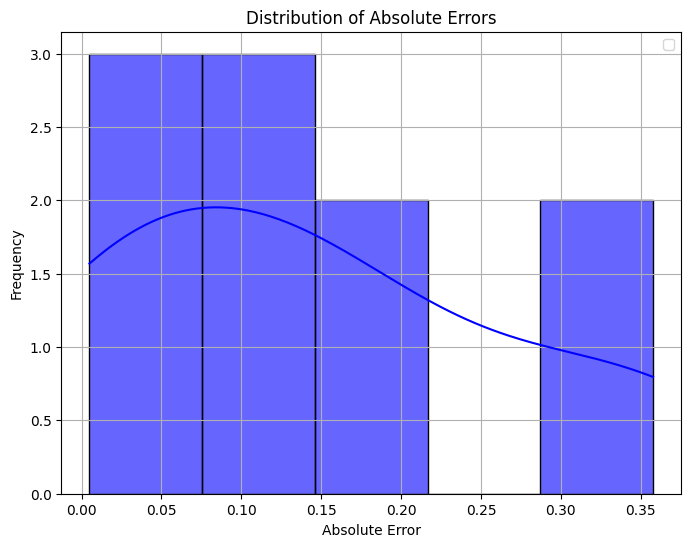

In [ ]:
validation_results_1.visualize_energy_gap(plot_type=PlotType.HISTOGRAM)

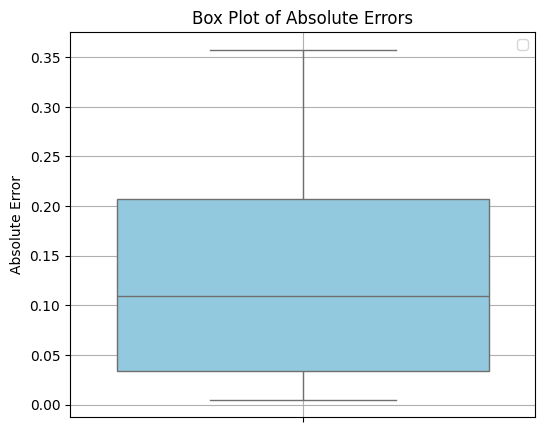

In [ ]:
validation_results_1.visualize_energy_gap(plot_type=PlotType.BOX)

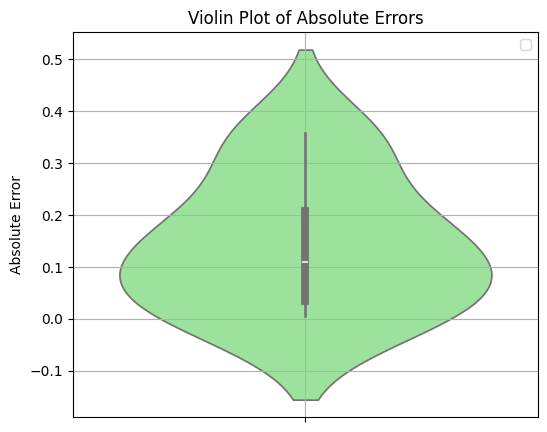

In [ ]:
validation_results_1.visualize_energy_gap(plot_type=PlotType.VIOLIN)

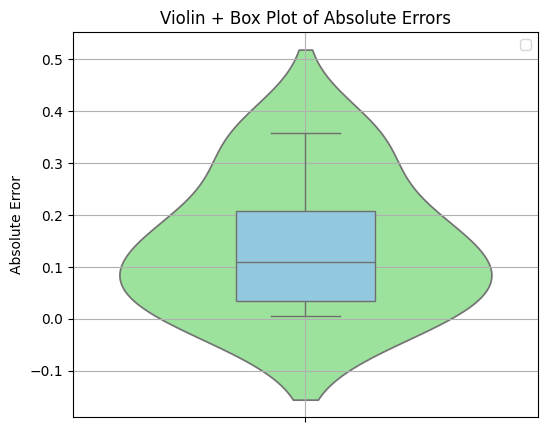

In [ ]:
validation_results_1.visualize_energy_gap(plot_type=PlotType.BOX_ON_VIOLIN)

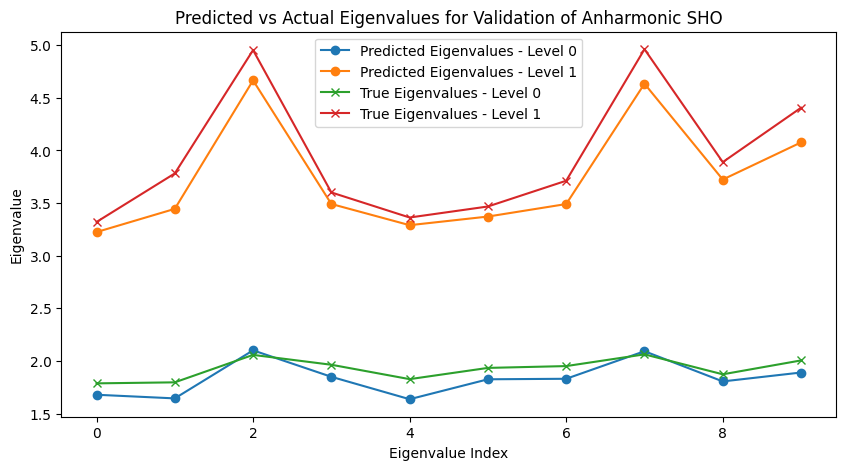

In [ ]:
validation_results_1.plot_eigen_values(title="Predicted vs Actual Eigenvalues for Validation of Anharmonic SHO")

## ROUND TWO - Train Joint Test Anharmonic

In [ ]:
import torch

In [ ]:
# Hyperparameters
num_samples = 500
grid_size = 30
num_eigenvalues = 2
learning_rate = 1e-3
num_epochs = 500

In [ ]:
well_train_potentials, well_train_eigen_vals = generate_potential_data(
    num_samples=num_samples,
    dx=0.1,
    dy=0.1,
    max_x_extent=3,
    max_y_extent=3,
    potential_type="well",
    device=device
)

In [ ]:
joint_train_potentials = torch.cat((train_potentials, well_train_potentials), dim=0)
joint_train_eigen_vals = torch.cat((train_eigen_vals, well_train_eigen_vals), dim=0)

In [ ]:
fno_model2 = FNO(
    n_modes=(10, 10),
    hidden_channels=16,
    in_channels=1,
    out_channels=num_eigenvalues,
    lifting_channels=128,
    projection_channels=128,
    n_layers=64
)

# Create optimizer and loss function
optimizer = optim.Adam(fno_model2.parameters(), lr=learning_rate)
loss_fn = nn.MSELoss()

fno_model2, optimizer, loss_fn = accelerator.prepare(fno_model2, optimizer, loss_fn)

In [ ]:
train_results_2 = train(
    TrainInput(
        train_potentials=joint_train_potentials,
        train_eigen_vals=joint_train_eigen_vals,
        model=fno_model2,
        device=device,
        loss_fn=loss_fn,
        num_epochs=num_epochs,
        optimizer=optimizer,
    ),
    accelerator=accelerator,
)

Training: 100%|██████████| 500/500 [03:52<00:00, 2.15epoch/s, loss=0.00362, avg_loss=0.422, time_elapsed=232.80s]


In [ ]:
train_results_2.save_to_file("train_result_2.pth")

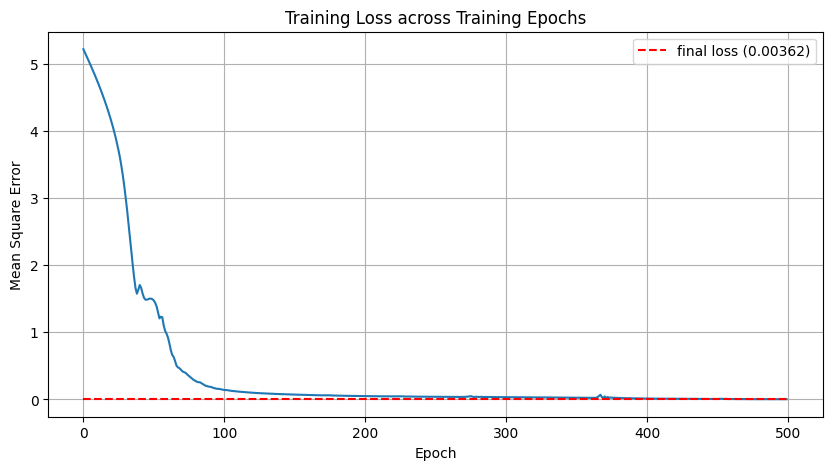

In [ ]:
train_results_2.plot_losses()

### Validation

In [ ]:
validation_results_2 = validate_model(
    ValidationInput(
        val_potentials=val_potentials,
        val_eigen_vals=val_eigen_vals,
        model=train_results_2.model,
        loss_fn=loss_fn,
    )
)

Validation Loss: 0.036706


In [ ]:
validation_results_2.save_to_file("validation_result_2.pth")

### Validation Errors

In [ ]:
validation_results_2.errors()

ValidationErrors(MRE=0.1019677072763443, MSE=0.06412788480520248, MAE=0.21545672416687012, R2=tensor(0.9781))

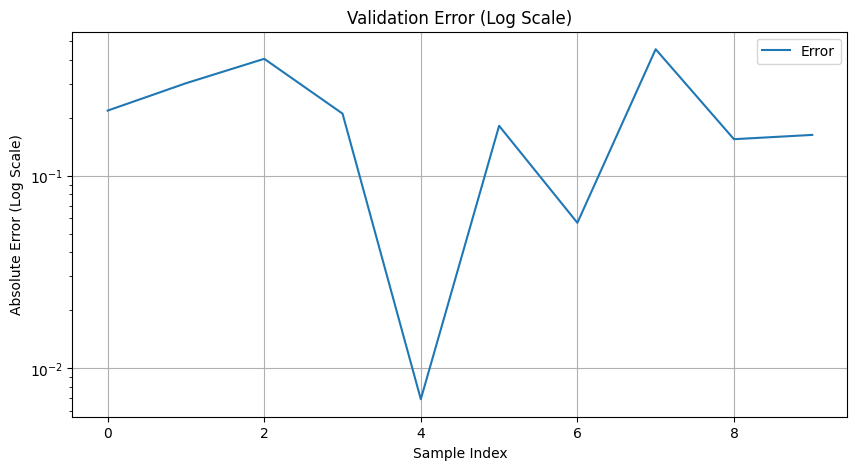

In [ ]:
validation_results_2.plot(error_type=ErrorType.ABSOLUTE)

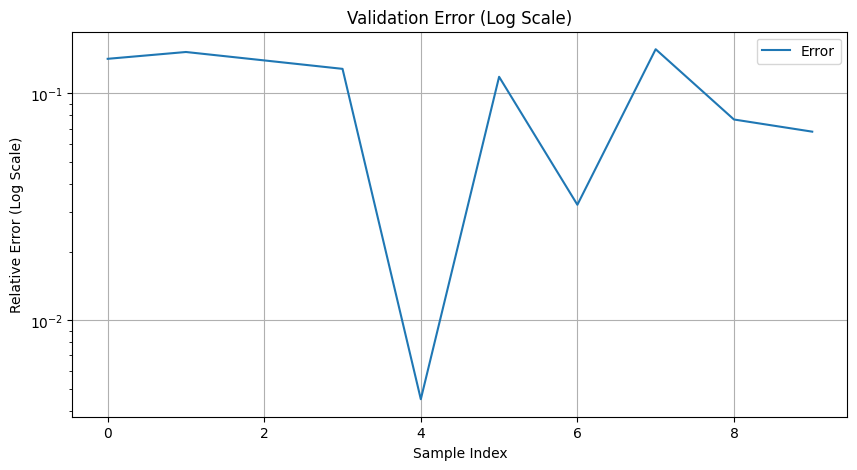

In [ ]:
validation_results_2.plot(error_type=ErrorType.RELATIVE)

### Validation Plots

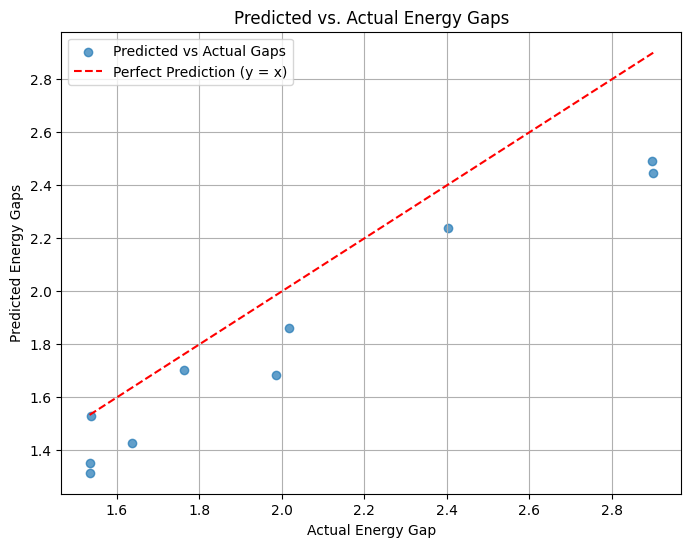

In [ ]:
validation_results_2.visualize_energy_gap(plot_type=PlotType.SCATTER)

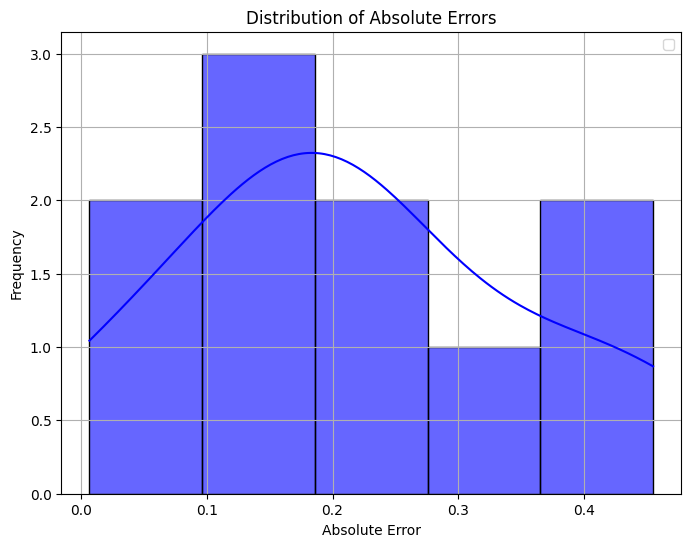

In [ ]:
validation_results_2.visualize_energy_gap(plot_type=PlotType.HISTOGRAM)

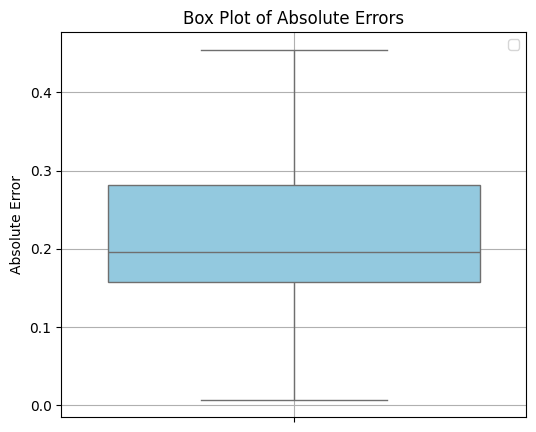

In [ ]:
validation_results_2.visualize_energy_gap(plot_type=PlotType.BOX)

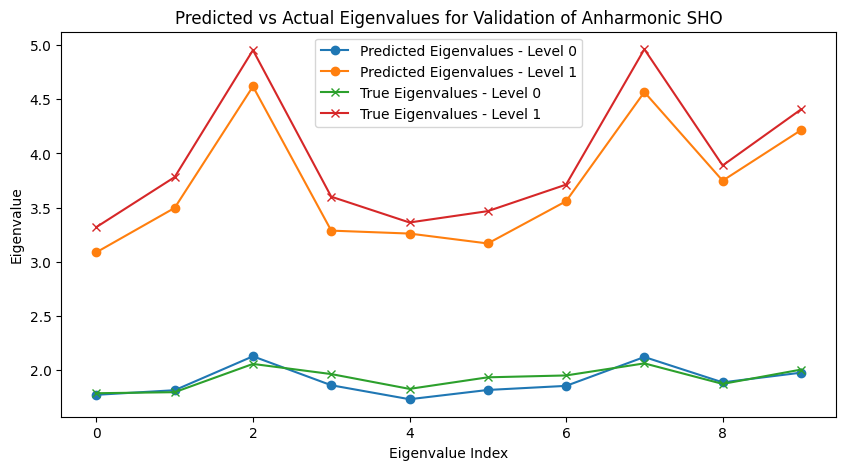

In [ ]:
validation_results_2.plot_eigen_values(title="Predicted vs Actual Eigenvalues for Validation of Anharmonic SHO")

In [4]:
config = Configuration(
    num_samples=num_samples,
    grid_size=grid_size,
    num_eigenvalues=num_eigenvalues,
    learning_rate=learning_rate,
    num_epochs=num_samples,
    n_modes=(10, 10),
    hidden_channels=16,
    in_channels=1,
    out_channels=num_eigenvalues,
    lifting_channels=128,
    projection_channels=128,
    n_layers=64
)


data_config_1 = DataConfiguration(
    dx=0.1,
    dy=0.1,
    max_x_extent=3,
    max_y_extent=3,
    potential_type="harmonic"
)

data_config_2 = DataConfiguration(
    dx=0.1,
    dy=0.1,
    max_x_extent=3,
    max_y_extent=3,
    potential_type="harmonic+well"
)


In [6]:
config.save_to_file("config_1.pth")
data_config_1.save_to_file("data_config_1.pth")
data_config_2.save_to_file("data_config_2.pth")